In [0]:
# Traffic Sign Classification set
!wget http://deeplearning.iit.bme.hu/CVS/trafficSignsHW.zip
!unzip -qq trafficSignsHW.zip
!rm trafficSignsHW.zip

--2020-04-26 20:10:10--  http://deeplearning.iit.bme.hu/CVS/trafficSignsHW.zip
Resolving deeplearning.iit.bme.hu (deeplearning.iit.bme.hu)... 152.66.243.112
Connecting to deeplearning.iit.bme.hu (deeplearning.iit.bme.hu)|152.66.243.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175675617 (168M) [application/zip]
Saving to: ‘trafficSignsHW.zip’

trafficSignsHW.zip  100%[===================>] 167.54M  11.9MB/s    in 15s     

2020-04-26 20:10:27 (11.0 MB/s) - ‘trafficSignsHW.zip’ saved [175675617/175675617]



In [0]:
import torch
import torch.nn as nn

# Convolutional module (Conv+ReLU+BatchNorm)
class Conv(nn.Module):
    
    # Constructor gets in and output channels and stride
    def __init__(self, in_channels, channels, stride=1):
        super(Conv, self).__init__()
        
        # Create 2D Convolution (3x3)
        self.conv = nn.Conv2d(in_channels, channels, kernel_size=3, stride=stride, padding=1, bias=False)
        
        # Create Batchnorm
        self.bn = nn.BatchNorm2d(channels)
        
    # Overwrite forward
    def forward(self,x):
        # Call the layers in the proper order
        return self.bn(torch.relu(self.conv(x)))

In [0]:
class ConvNet(nn.Module):
    
    # Constructor gets channel number of the image and the first filter
    def __init__(self, base_channels=16, in_channels=3, num_classes=52):
        super(ConvNet, self).__init__()
        
        # First two filters
        self.c11 = Conv(in_channels, base_channels)
        self.c12 = Conv(base_channels, base_channels)
        
        # Downscale using strided convolution and expand channels
        self.d1 = Conv(base_channels, base_channels*2, 2)
        
        # Repeat this 4 times
        self.c21 = Conv(base_channels*2, base_channels*2)
        self.c22 = Conv(base_channels*2, base_channels*2)
        
        self.d2 = Conv(base_channels*2, base_channels*4, 2)
        
        self.c31 = Conv(base_channels*4, base_channels*4)
        self.c32 = Conv(base_channels*4, base_channels*4)
        
        self.d3 = Conv(base_channels*4, base_channels*8, 2)
        
        self.c41 = Conv(base_channels*8, base_channels*8)
        self.c42 = Conv(base_channels*8, base_channels*8)
        
        self.d4 = Conv(base_channels*8, base_channels*16, 2)
        
        self.c51 = Conv(base_channels*16, base_channels*16)
        self.c52 = Conv(base_channels*16, base_channels*16)
        
        # Input image is 32x32 -> after 5 downscaling the activation map is 1x1
        self.d5 = Conv(base_channels*16, base_channels*32, 2)
        
        # Classifier is a normal 1x1 convolution that produces num_classes class scores
        # This layer does not have BatchNorm of ReLU
        self.classifier = nn.Conv2d(base_channels*32,num_classes,kernel_size=1)
        
    def forward(self,x):
        # Class all the layers
        x = self.d1(self.c12(self.c11(x)))
        x = self.d2(self.c22(self.c21(x)))
        x = self.d3(self.c32(self.c31(x)))
        x = self.d4(self.c42(self.c41(x)))
        x = self.d5(self.c52(self.c51(x)))
        
        # Squeeze removes dimensions that have only 1 element
        # Output of the conv layer is (batch_size x num_classes x 1 x 1)
        # After squeeze is becomes (batch_size x num_classes)
        return torch.squeeze(self.classifier(x))

In [0]:
haveCuda = torch.cuda.is_available()
print(haveCuda)

True


In [0]:
from torchvision import transforms

# Necessary transformations: conversion to PyTorch Tensor and normalization
# Normalization is performed with channels-wise means and variances computed on ImageNet
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                         (0.24703233, 0.24348505, 0.26158768))
])

# Train database transform includes data augmentation
transform = transforms.Compose([
    # Random 32x32 crops (with 4-wide zero padding - this is needed because the 
    # input is 32x32 so we can't crop a 32x32 region out of it without padding)
    transforms.RandomCrop(32,padding=4),
    # Flips horizontally with p=0.5
    # transforms.RandomHorizontalFlip(),
    # Random perturbance of brightness, contrast and color
    transforms.ColorJitter(brightness=0.3,contrast=0.3,saturation=0.3,hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                         (0.24703233, 0.24348505, 0.26158768))
])

In [0]:
import torchvision

# Trainsets automatically download the dataset if not present
trainSet = torchvision.datasets.ImageFolder(root='/content/trafficSignsHW/trainFULL', transform=transform)
testSet = torchvision.datasets.ImageFolder(root='/content/trafficSignsHW/testFULL', transform=transform_val)

In [0]:
# Dataloaders are responsible for giving random (if shuffle is true) minibatches
train_size = int(0.9 * len(trainSet))
valid_size = len(trainSet) - train_size
train_set_rand, valid_set_rand = torch.utils.data.random_split(trainSet, [train_size, valid_size])
trainLoader = torch.utils.data.DataLoader(train_set_rand, batch_size=128, shuffle=True)
validLoader = torch.utils.data.DataLoader(valid_set_rand, batch_size=128, shuffle=True)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=128, shuffle=True)

In [0]:
# Instantiate network and convert it to CUDA
def createNet():
    net = ConvNet()
    if haveCuda:
        net = net.cuda()
    return net

In [0]:
# We use cros entropy, since CIFAR10 is a classification set
def createLoss():
    return nn.CrossEntropyLoss()

In [0]:
from torch import optim
# Stochastic Gradient Descent (SGD) optimizer with Nesterov momentum and 0.1 learning rate
# Weight decay is the relative weight of the L2 regularization term
def createOptimizer():
    return optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [0]:
# Run for 50 epochs - 1 epoch means the networks sees every training image once
numEpoch = 10

# Cosine annealing learning rate scheduler - in 50 epochs the lr will become 0.01
def createScheduler():
    return optim.lr_scheduler.CosineAnnealingLR(optimizer,numEpoch,eta_min=1e-2)

In [0]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [0]:
# Function for training a single epch
def train(epoch):

    # variables for loss
    running_loss = 0.0
    correct = 0.0
    total = 0

    # set the network to train (for batchnorm and dropout)
    net.train()

    # Create progress bar
    bar = display(progress(0, len(trainLoader)), display_id=True)

    # data will contain one minibatch of images and correcponding labels
    # When the iteration is finished we have seen every training image once
    for i, data in enumerate(trainLoader, 0):
        # get the inputs
        inputs, labels = data

        # Convert to cuda
        if haveCuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        # Clear any previous gradients
        optimizer.zero_grad()

        # Forward
        outputs = net(inputs)
        # Loss
        loss = criterion(outputs, labels)
        # Backpropagation
        loss.backward()
        # Gradient method
        optimizer.step()

        # Do not include these steps in the computational graph
        with torch.no_grad():
            # Accumulate loss
            running_loss += loss.item()
            # Get indices of the largest goodness values
            _, predicted = torch.max(outputs, 1)
            # Count how many of the predictions equal the labels
            correct += predicted.eq(labels).sum().item()
            # Accumulate number of total images seen
            total += labels.size(0)

        # Progress bar
        bar.update(progress(i+1, len(trainLoader)))

    # return loss and accuracy
    tr_loss = running_loss / i
    tr_corr = correct / total * 100
    print("Train epoch %d loss: %.3f correct: %.2f" % (epoch + 1, running_loss / i, tr_corr))
    return tr_loss,tr_corr

In [0]:
# Function for validating a single epch
def val(epoch):

    # variables for loss
    running_loss = 0.0
    correct = 0.0
    total = 0

    # set the network to eval  (for batchnorm and dropout)
    net.eval()

    # Create progress bar
    bar = display(progress(0, len(validLoader)), display_id=True)

    for i, data in enumerate(validLoader, 0):
        # get the inputs
        inputs, labels = data

        # Convert to cuda
        if haveCuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        # Do not include these steps in the computational graph
        with torch.no_grad():
            # Forward
            outputs = net(inputs)
            # Compute loss
            loss = criterion(outputs, labels)

            # Compute statistics, just like before
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        bar.update(progress(i+1, len(validLoader)))

    # return loss and accuracy
    val_loss = running_loss / i
    val_corr = correct / total * 100
    print("Test epoch %d loss: %.3f correct: %.2f" % (epoch + 1, running_loss / i, val_corr))
    return val_loss,val_corr

In [0]:
# Containers for losses and accuracies for every epoch
train_accs = []
train_losses = []
val_accs = []
val_losses = []

# Best validation accuracy
best_acc = 0

# Set pseudo-random generator seeds to make multiple runs comparable
torch.manual_seed(1)
if haveCuda:
    torch.cuda.manual_seed(1)

# Create net, criterion, optimizer and scheduler
# This needs to be done after setting the random seed, 
# so that the random initialization would be the same
net = createNet()
criterion = createLoss()
optimizer = createOptimizer()
scheduler = createScheduler()

# For numEpoch epochs
for epoch in range(numEpoch):
    
    # The with the LR scheduler
    scheduler.step()
    
    # Train
    loss,acc = train(epoch)
    train_accs.append(acc)
    train_losses.append(loss)
    
    # Validate
    loss,acc = val(epoch)
    val_accs.append(acc)
    val_losses.append(loss)
    
    # If the current model is better, than the previous best, save it
    if acc > best_acc:
        print("Best Model, Saving")
        best_acc = acc
        torch.save(net,"/content/trafficSignsHW/model.pth")

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train epoch 1 loss: 1.825 correct: 49.44


Test epoch 1 loss: 0.439 correct: 86.85
Best Model, Saving


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Conv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Train epoch 2 loss: 0.175 correct: 94.62


Test epoch 2 loss: 0.150 correct: 95.68
Best Model, Saving


Train epoch 3 loss: 0.084 correct: 97.51


Test epoch 3 loss: 0.069 correct: 97.94
Best Model, Saving


Train epoch 4 loss: 0.060 correct: 98.20


Test epoch 4 loss: 0.049 correct: 98.49
Best Model, Saving


Train epoch 5 loss: 0.042 correct: 98.79


Test epoch 5 loss: 0.038 correct: 98.96
Best Model, Saving


Train epoch 6 loss: 0.032 correct: 99.04


Test epoch 6 loss: 0.026 correct: 99.30
Best Model, Saving


Train epoch 7 loss: 0.024 correct: 99.30


Test epoch 7 loss: 0.021 correct: 99.39
Best Model, Saving


Train epoch 8 loss: 0.019 correct: 99.44


Test epoch 8 loss: 0.019 correct: 99.39


Train epoch 9 loss: 0.016 correct: 99.53


Test epoch 9 loss: 0.017 correct: 99.50
Best Model, Saving


Train epoch 10 loss: 0.014 correct: 99.61


Test epoch 10 loss: 0.015 correct: 99.55
Best Model, Saving


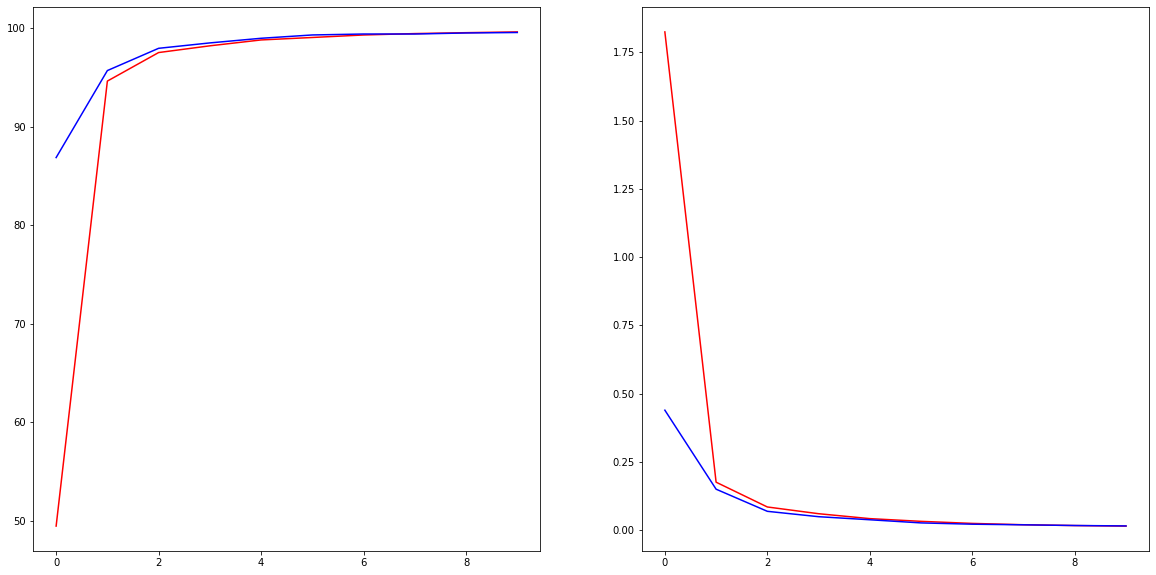

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# X coordinate for plotting
x = np.arange(numEpoch)

plt.figure(figsize=(20,10))

# Train is red, validation is blue
plt.subplot(1,2,1)
plt.plot(x,train_accs,'r')
plt.plot(x,val_accs,'b')

plt.subplot(1,2,2)
plt.plot(x,train_losses,'r')
plt.plot(x,val_losses,'b')

plt.show()

In [0]:
correct = 0
total = 0
for i, data in enumerate(testLoader, 0):
  images, labels = data
  if haveCuda:
    images, labels = images.cuda(), labels.cuda()
  with torch.no_grad():
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10418 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10418 test images: 99 %


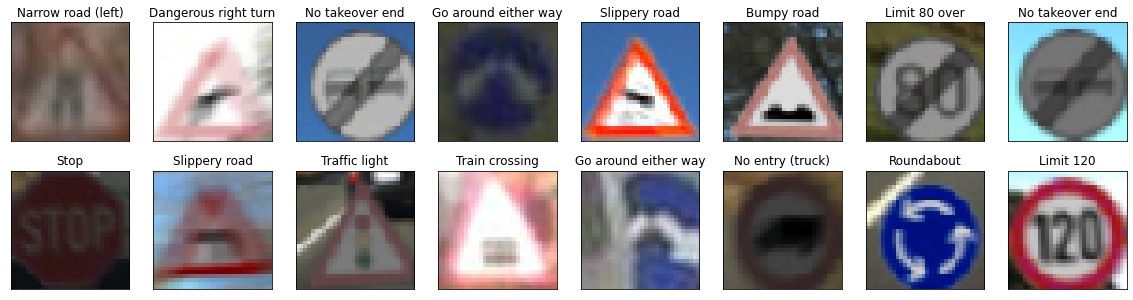

In [0]:
# Get a minibatch from the test loader and convert to cuda
inputs, labels = next(iter(testLoader))
if haveCuda:
    inputs, labels = inputs.cuda(), labels.cuda()

# forward
outputs = net(inputs)

# Get predicted class indices
_, predicted = torch.max(outputs, 1)

# Values used for normalization
mean = torch.Tensor((0.49139968, 0.48215827, 0.44653124)).unsqueeze(1).unsqueeze(1)
std = torch.Tensor((0.24703233, 0.24348505, 0.26158768)).unsqueeze(1).unsqueeze(1)

# Class names
classes = ('Bump', 'Bumpy road', 'Bus stop', 'Children', 'Crossing (blue)', 'Crossing (red)', 'Cyclists',
     'Danger (other)', 'Dangerous left turn', 'Dangerous right turn', 'Give way', 'Go ahead', 'Go ahead or left',
     'Go ahead or right', 'Go around either way', 'Go around left', 'Go around right', 'Intersection', 'Limit 100',
     'Limit 120', 'Limit 20', 'Limit 30', 'Limit 50', 'Limit 60', 'Limit 70', 'Limit 80', 'Limit 80 over',
     'Limit over', 'Main road', 'Main road over', 'Multiple dangerous turns', 'Narrow road (left)',
     'Narrow road (right)', 'No entry', 'No entry (both directions)', 'No entry (truck)', 'No stopping', 'No takeover',
     'No takeover (truck)', 'No takeover (truck) end', 'No takeover end', 'No waiting', 'One way road',
     'Parking', 'Road works', 'Roundabout', 'Slippery road', 'Stop', 'Traffic light', 'Train crossing',
     'Train crossing (no barrier)', 'Wild animals')

# List of subplots - we'll use 16 images
f, axarr = plt.subplots(2, 8,figsize=(20, 5))

# For every image-prediction pair
for i,(img,pred) in enumerate(zip(inputs,predicted)):
    # undo the normalization
    img_rescaled = img.cpu() * std + mean
    
    # Get predicted class name
    name = classes[pred.cpu().item()]
    
    # Permutation needed because in PyTorch the channel dimension comes first,
    # but in numpy and opencv it comes last (3x32x32) -> (32x32x3)
    axarr[i//8,i%8].imshow(img_rescaled.permute(1,2,0))
    
    # Set title to class name
    axarr[i//8,i%8].set_title(name)
    
    # Hide grid lines
    axarr[i//8,i%8].grid(False)
    
    # Hide axes ticks
    axarr[i//8,i%8].set_xticks([])
    axarr[i//8,i%8].set_yticks([])
    
    # Only do the first 16
    if i == 15:
        break